# Understanding Shap Values

#### This notebook demonstrates how to: 

1. Plot SHAP Values in relation to the segmentation predictions
2. Assess SHAP values from a single example
3. Assess multiple SHAP values to make some global observations

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd

### Load saved data, shap values and model

In [2]:
# List the indexes used as examples when generating the shap values in explain.py
idxs = [127, 527, 259, 401, 210, 90, 610, 600, 24]

# Load the test data examples used for generating SHAP values
x_test = np.load('outputs/x_test.npy')[idxs]
y_test = np.load('outputs/y_test.npy')[idxs]

# Load shap values and expected values
shap_values = np.load('outputs/shap_values.npy')
expected_values = np.load('outputs/expected_values.npy')

# Load trained model
model = tf.keras.models.load_model('outputs/model')

# Predict the specific examples. Note whatever decimation was used for training must also be used here. 
y_pred = model.predict(x_test[:, ::2, ::2, :])

### Process SHAP values into channel contributions. 

The SHAP values need converting into channel contributions so they can be easily interpretable. Channel contributions tell us how much each channel in the input image contributes to the final prediction. 


In [3]:
# Function for processing Shap Array
def get_channel_contributions(shap_values: np.ndarray) -> np.ndarray:
    
    """
    Converts SHAP values into channel contributions. 
    """

    n_pixels, n_samples, n_img_size, _, n_channels = shap_values.shape

    swaped_shap_values = np.swapaxes(shap_values, 0, 1)
    
    channel_contributions = []
    for sample_n in range(n_samples):
    
        sample = swaped_shap_values[sample_n]
        summed_contributions = sample.sum(axis=1).sum(axis=1)
        channel_contributions.append(
            summed_contributions.reshape(n_img_size, n_img_size, n_channels)
            )

    channel_contributions = np.array(channel_contributions)

    return channel_contributions

Channel contributions are generated. They have shape: (num_of_examples, img_xdim, img_ydim, num_of_channels)

In [4]:
channel_contributions = get_channel_contributions(shap_values)
channel_contributions.shape

(9, 24, 24, 4)

### Upscale all images from 24x24 to 48x48

Simply to make the images less blurry, we can resample all the images to a certain size. In this case, we will upsample the images back from 24x24 to 48x48. This is done for the inputs, predictions and channel contributions.  

In [5]:
def resize_image(input_image, new_shape=[48, 48], **kwargs):
    """
    Resizes set of images. Note the dimension of the input must (num_of_examples, xdim, ydim, channels).
    """
    return tf.image.resize(tf.convert_to_tensor(input_image), new_shape, **kwargs).numpy()

In [6]:
resized_channel_contributions = resize_image(channel_contributions)
resized_expected_value = resize_image(np.expand_dims(expected_values, -1))
resized_y_pred = resize_image(y_pred)
resized_expected_values = resize_image(np.expand_dims(expected_values, -1))[: ,:, 0]

### Expected Values

The expected value can be thought of as the baseline of the trained model. It is usually similar to the mean label. Note in this case, the expected values are not at 0.5 which would indicate a mean between a masked pixel and non-masked pixel. However, there are lots of examples in the dataset with no salt at all. Therefore, the average is below 0.5 --> ~0.35

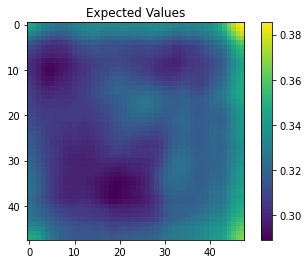

In [7]:
fig, ax = plt.subplots()
im = ax.imshow(resized_expected_values)
plt.colorbar(im, ax=ax)
plt.title('Expected Values')
fig.savefig('Figures/Expected_Values')

### Plotting Channel Contributions

The function below plots a (2, 5) plot figure.
The top row is from left to right: True Mask, Seismic, Amplitude, Semblance, Sobel Filter 
The bottom row is from left to right: Predicted Mask, Seismic Contribution, Amplitude Contribution, Semblance Contribution, Sobel Filter Contribution.  

The below code plots all the available examples

In [8]:
def plot_x_and_y(x_example, y_example, attribute_contributions, y_pred, idx=''):
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    
    # Calculate max absolute values for settign consistent colorbars
    x_example_max = np.amax(np.abs(x_example), axis=(0, 1))
    attribute_contributions_abs = np.amax(np.abs(attribute_contributions), axis=(0, 1))
    
    # Plot the top row
    i = 0
    for ax, title in zip(axes[0], ['Mask', 'Seismic', 'Amplitude', 'Semblance', 'Sobel Filter']):
    
        if title == 'Mask':
            im = ax.imshow(y_example[:, :, 0], vmin=0, vmax=1)
        elif title == 'Seismic' :
            im = ax.imshow(x_example[:, :, 0], cmap='gray', vmin=-x_example_max[0], vmax=x_example_max[0])
        else:
            im = ax.imshow(x_example[:, :, i-1], cmap='bwr', vmin=-x_example_max[i-1], vmax=x_example_max[i-1])
        i+=1
        
        plt.colorbar(im, ax=ax)
        ax.set_title(f'{title}_{idx}')
        
    # Plot the bottom row
    i = 0
    for ax, title in zip(axes[1], ['Predicted Mask', 'Seismic_Contribution', 'Amplitude Contribution',
                                     'Semblance Contribution', 'Sobel Filter Contribution']):
    
        if title == 'Predicted Mask':
            im = ax.imshow(y_pred[:, :, 0], vmin=0, vmax=1)
        else:
            im = ax.imshow(attribute_contributions[:, :, i-1], cmap='bwr', vmin=-attribute_contributions_abs[i-1],
                           vmax=attribute_contributions_abs[i-1])
        i+=1
                
        plt.colorbar(im, ax=ax)
        ax.set_title(f'{title}_{idx}')
    
    return fig
        

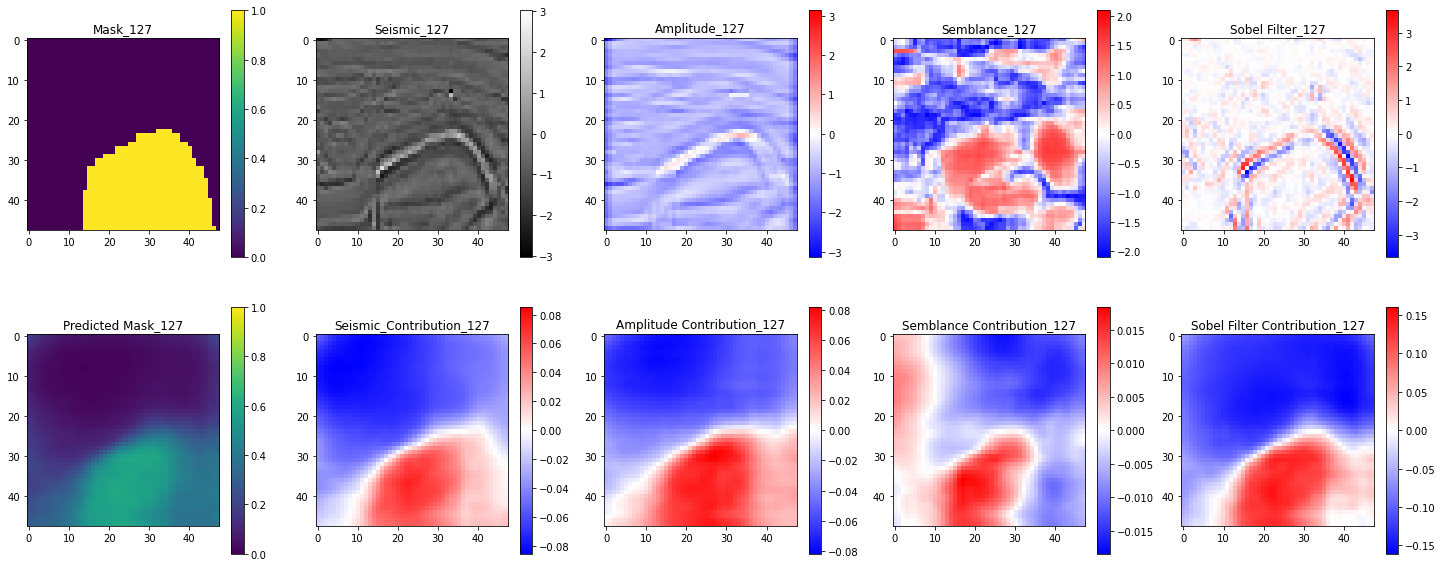

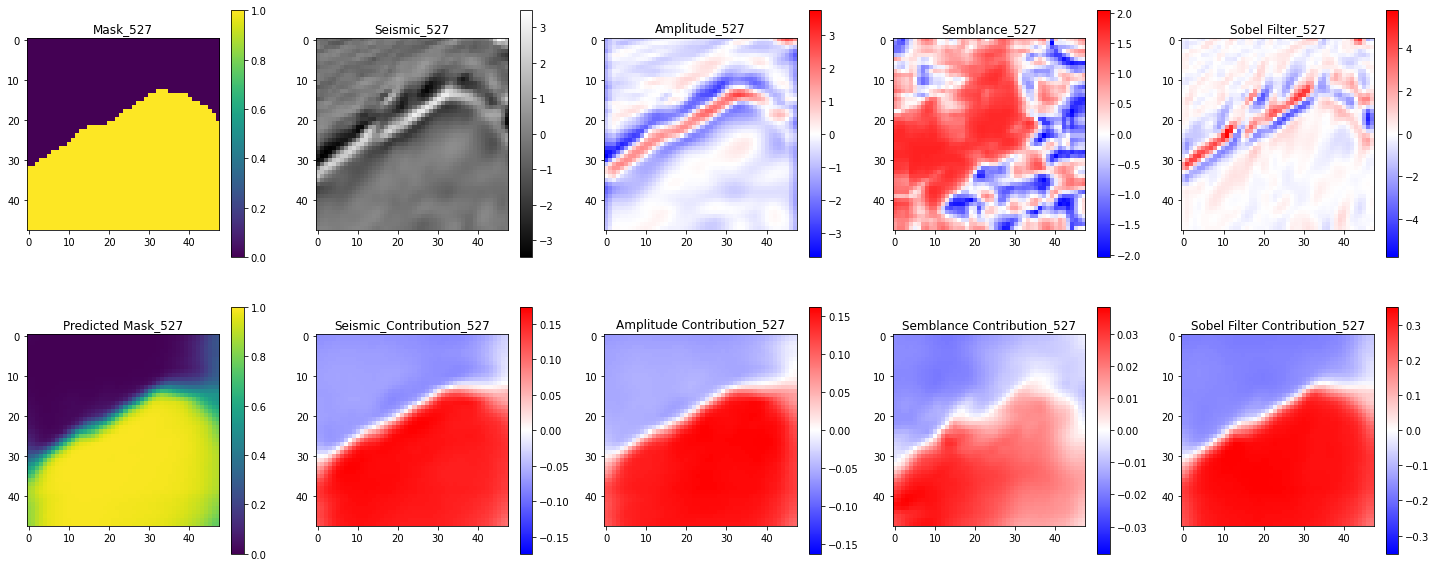

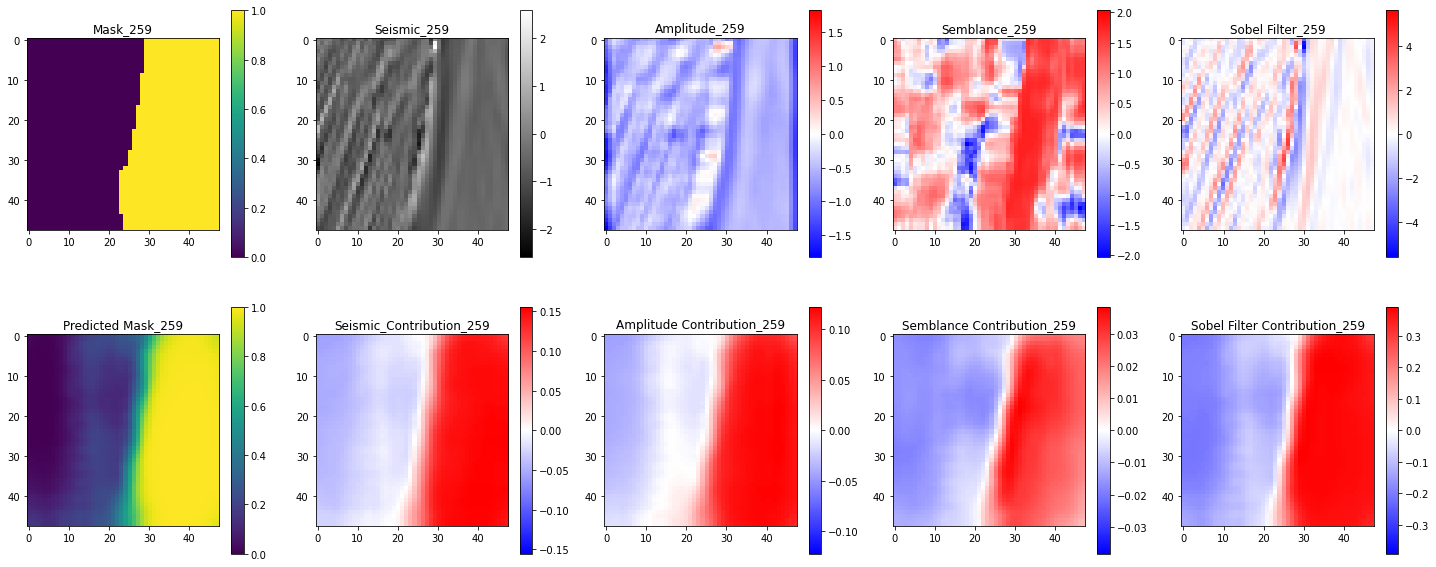

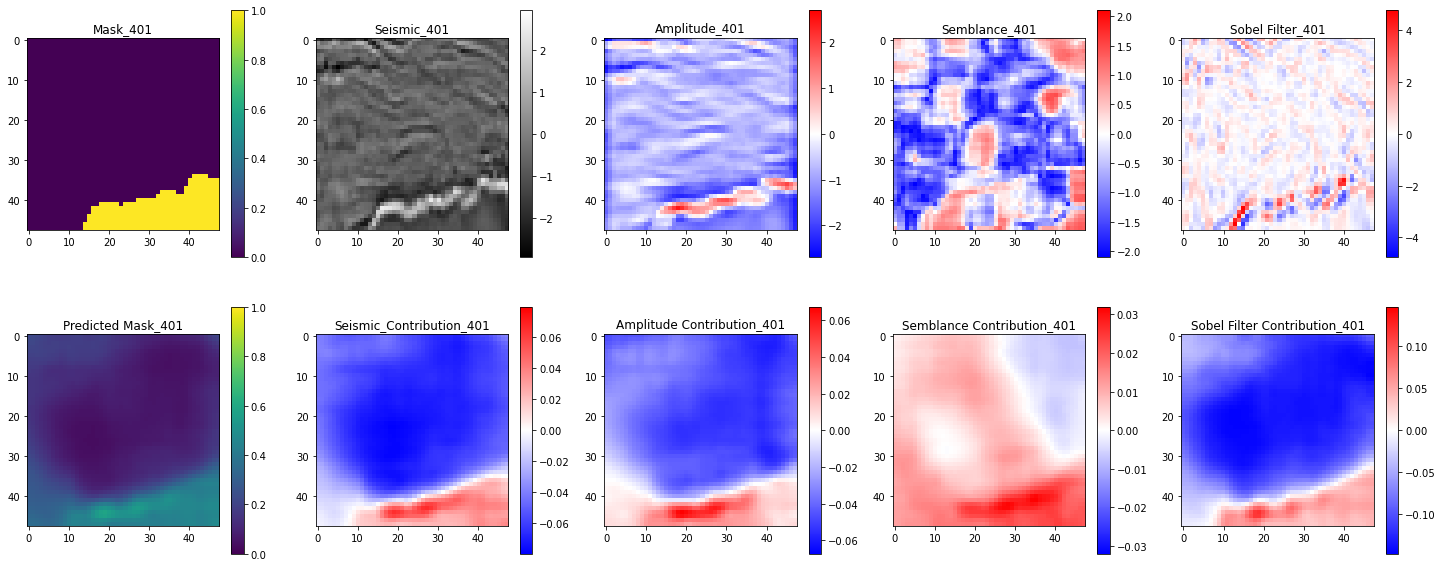

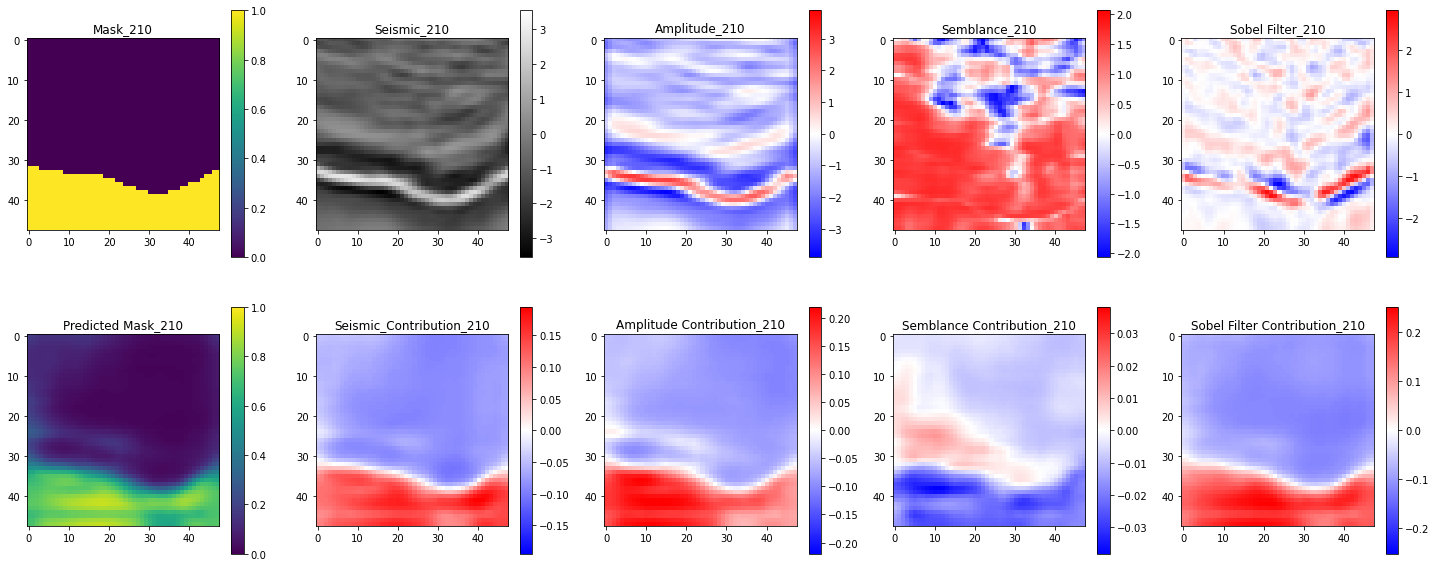

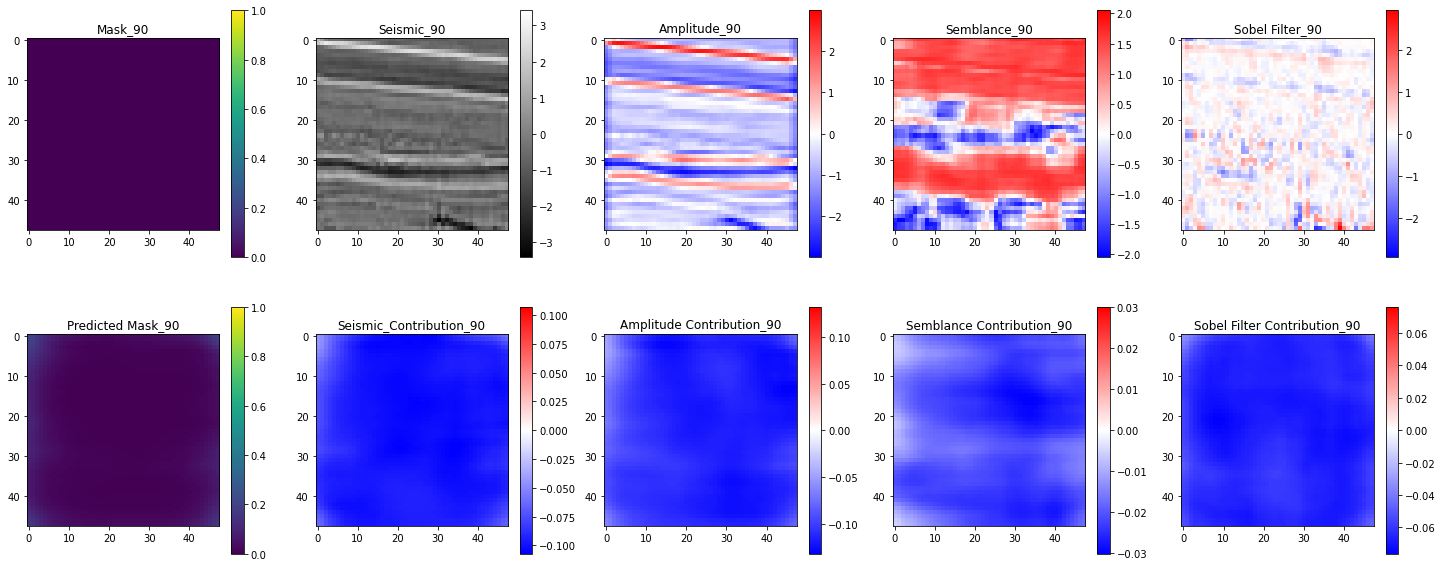

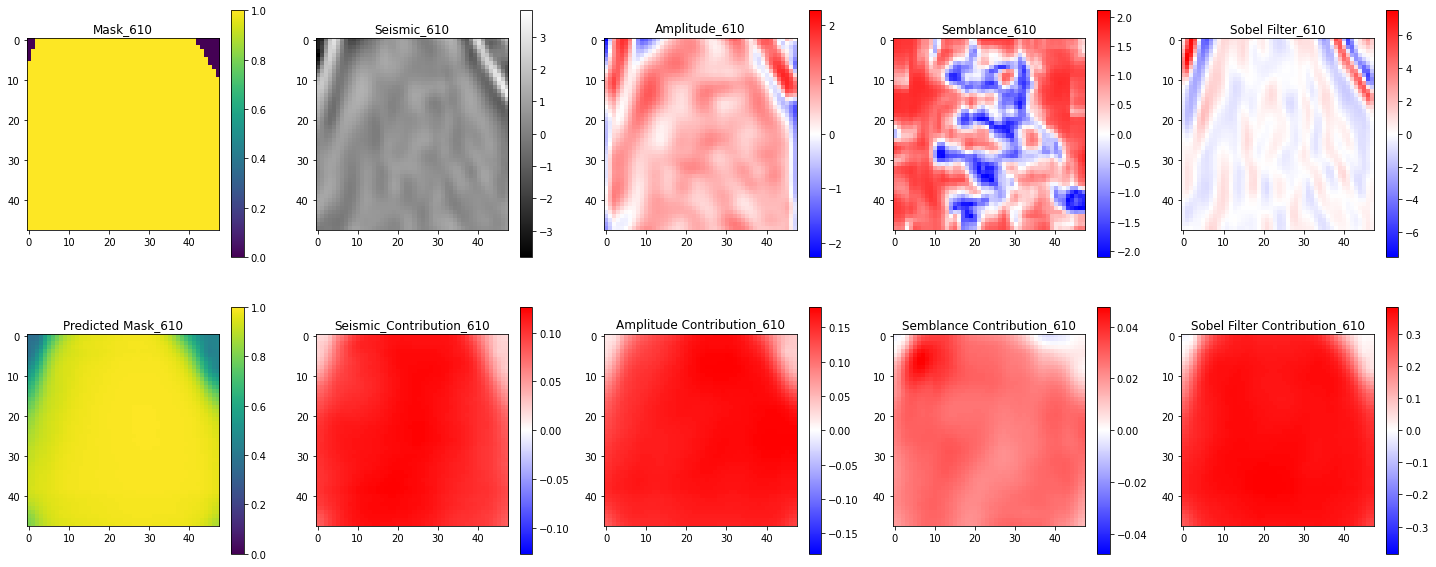

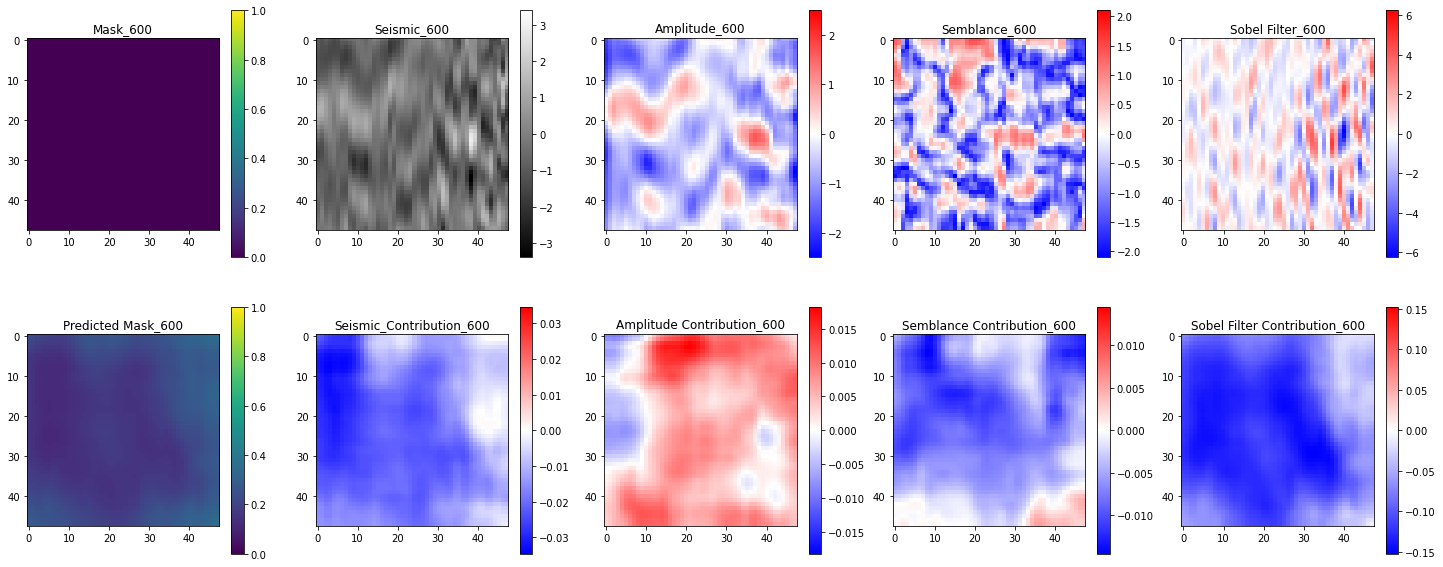

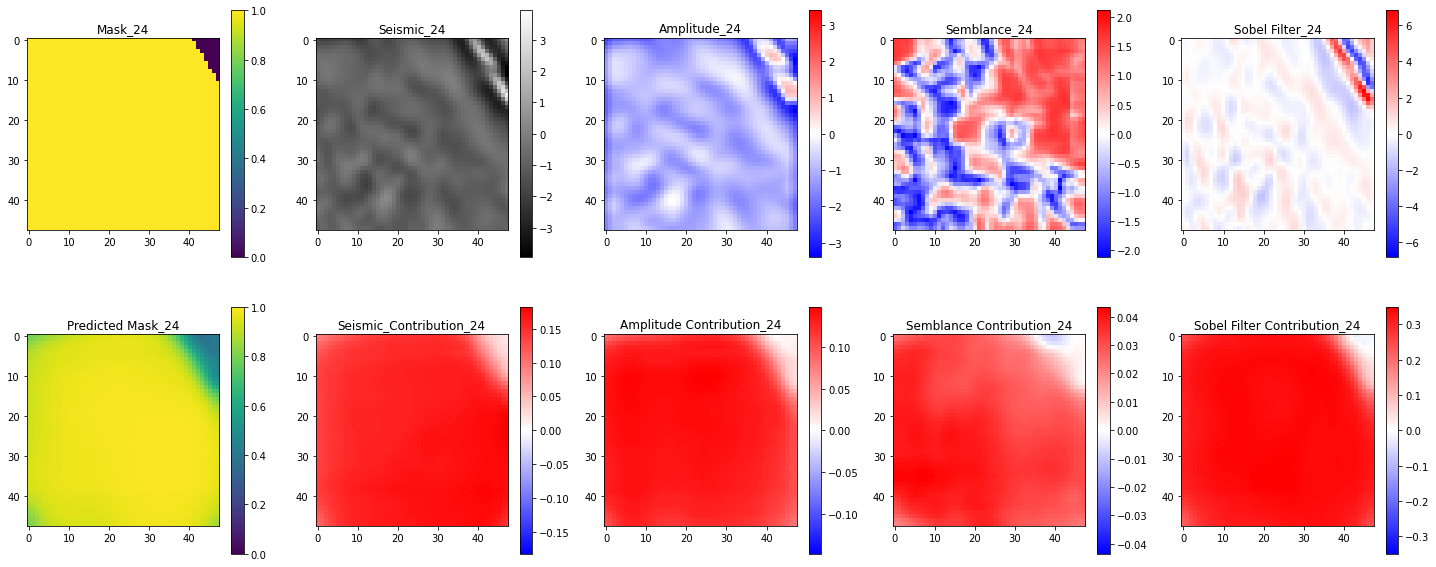

In [9]:
for i in range(len(idxs)):
    fig = plot_x_and_y(x_test[i], y_test[i], resized_channel_contributions[i], resized_y_pred[i], idx=idxs[i])
    fig.savefig(f'Figures/Channel_Contributions_{idxs[i]}')

### Single Example Analysis

Lets look at a single example in more detail. 

First lets plot the channel contributions again.

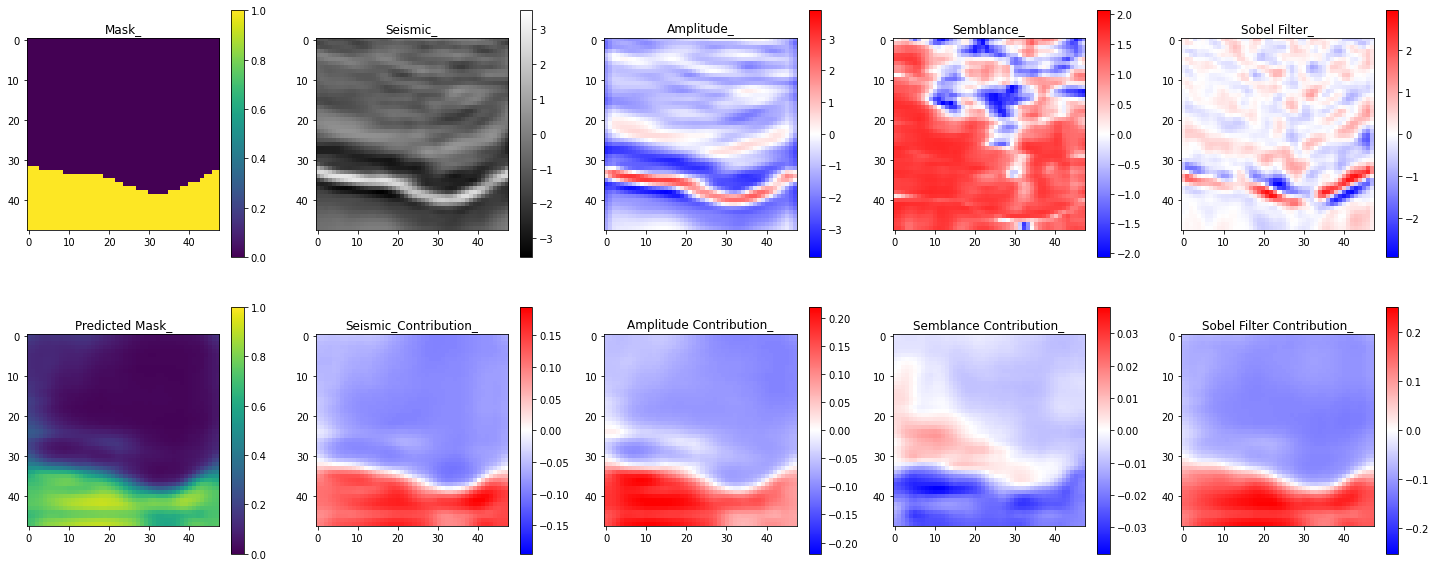

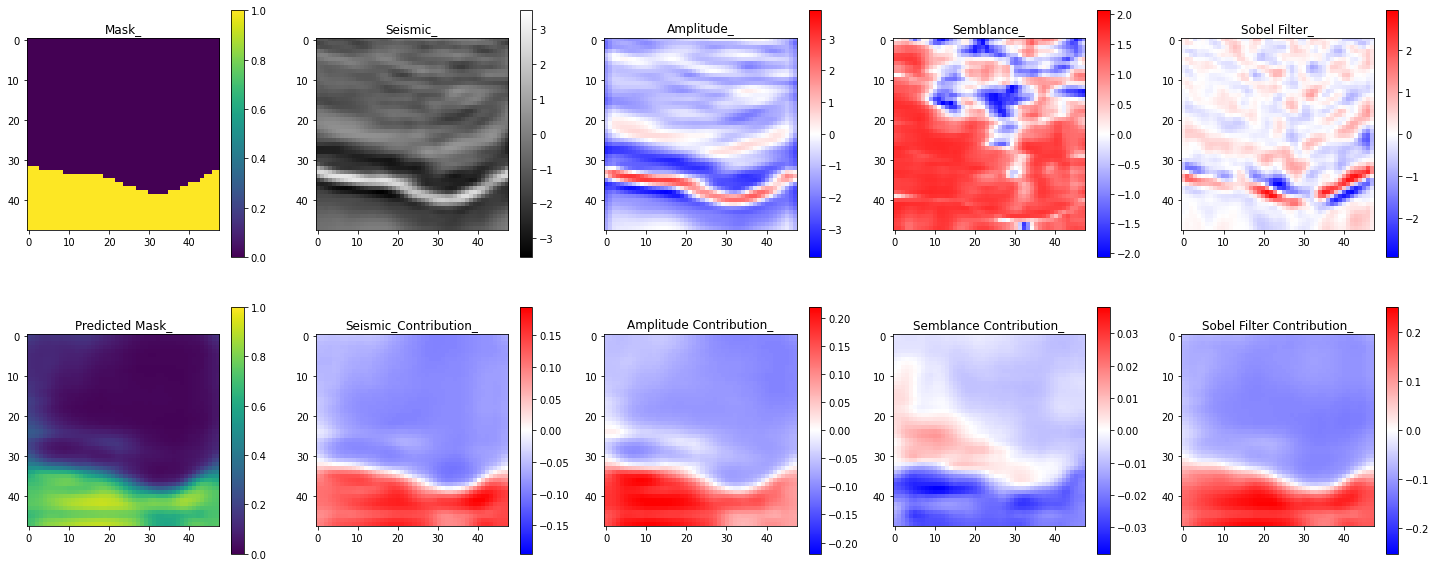

In [10]:
example_id = 4
plot_x_and_y(x_test[example_id], y_test[example_id], resized_channel_contributions[example_id], resized_y_pred[example_id])

Channel contributions tell us the numerical impact each channel of the input is having on the predicted. 
The basic principle is: 

**expected_value + channel_contributions = predicted_mask**

Below we plot this one by one to see the progression of adding each channels contribution to the result. 

In [11]:
def plot_image(image, ax, title=None, **kwargs):
    im = ax.imshow(image, vmin=0, vmax=1)
    plt.colorbar(im, ax=ax)
    ax.set_title(title)

In [12]:
image_dict = {
    'Expected_Values': resized_expected_values, 
    'Seismic_Contrib': resized_channel_contributions[example_id, :, :, 0], 
    'Amplitude_Contrib': resized_channel_contributions[example_id, :, :, 1], 
    'Semblance_Contrib': resized_channel_contributions[example_id, :, :, 2], 
    'Sobel_Contrib': resized_channel_contributions[example_id, :, :, 3], 
    'y_pred': resized_y_pred[example_id], 
    'y_true': y_test[example_id]
}

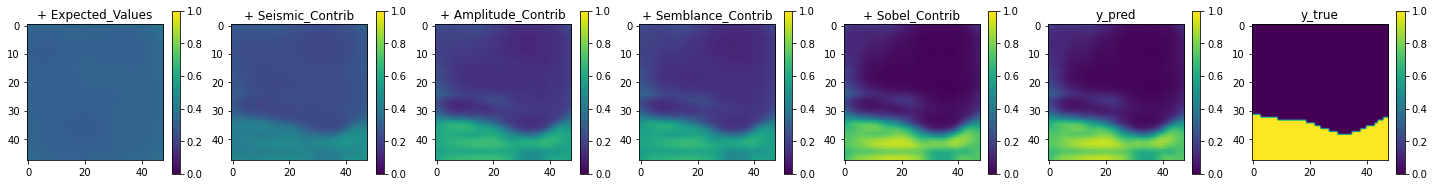

In [13]:
fig, axes = plt.subplots(1, 7, figsize=(25, 3))

i = 0
image = np.zeros(shape=resized_expected_values.shape)
title = []
for name, values in image_dict.items():
    
    if i < 5:
        image += values
        #title += f'+{name}'

        plot_image(image, axes[i], title=f'+ {name}')
        
    else:
        plot_image(values, axes[i], title=name)
        
    i+=1
    
fig.savefig('Figures/Additive_Channel_Contributions')

The picture above shows exactly how the network got to its prediction. 

### Global Channel Contribution Analysis

Is there a relationship between the pixel value of a channel (feature), its contribution and whether that pixel belongs to salt or not? 

Lets find out! To do this, we will use pandas and seaborn libraries.


In [14]:
# First create a df with all the data in
data_dict = {
    'Expected_Values': np.repeat(np.expand_dims(resized_expected_values, axis=0), len(x_test), axis=0).flatten(),
    'Seismic': x_test[:, :, :, 0].flatten(), 
    'Amplitude': x_test[:, :, :, 1].flatten(), 
    'Semblance': x_test[:, :, :, 2].flatten(), 
    'Sobel': x_test[:, :, :, 3].flatten(), 
    'Seismic_Contrib': resized_channel_contributions[:, :, :, 0].flatten(), 
    'Amplitude_Contrib': resized_channel_contributions[:, :, :, 1].flatten(), 
    'Semblance_Contrib': resized_channel_contributions[:, :, :, 2].flatten(), 
    'Sobel_Contrib': resized_channel_contributions[:, :, :, 3].flatten(), 
    'y_pred': resized_y_pred.flatten(), 
    'y_true': y_test.flatten()
}

data_df = pd.DataFrame(data_dict)

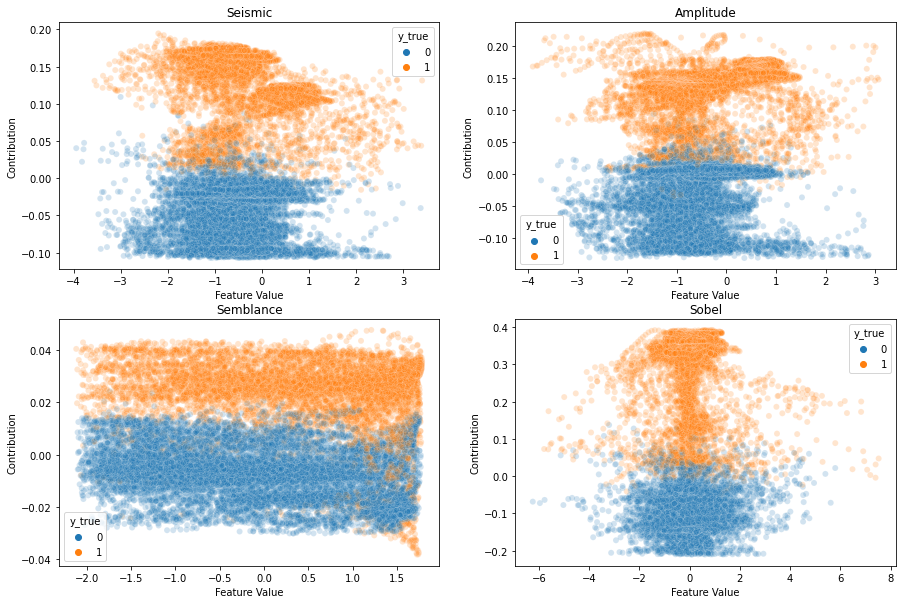

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, title in zip(axes.flat, ['Seismic', 'Amplitude', 'Semblance', 'Sobel']):
    
    sns.scatterplot(data=data_df, x=title, y=f'{title}_Contrib', 
               hue='y_true', ax=ax, alpha=0.2)
    
    ax.set_title(title)
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Contribution')
    
fig.savefig('Figures/Global_Channel_Contribution_Analysis_part1')


Interesting! Now we can plot all on the same axis to see how different features compare to each other. To do this, we'll split the data by whether they are mask or not mask pixels. 

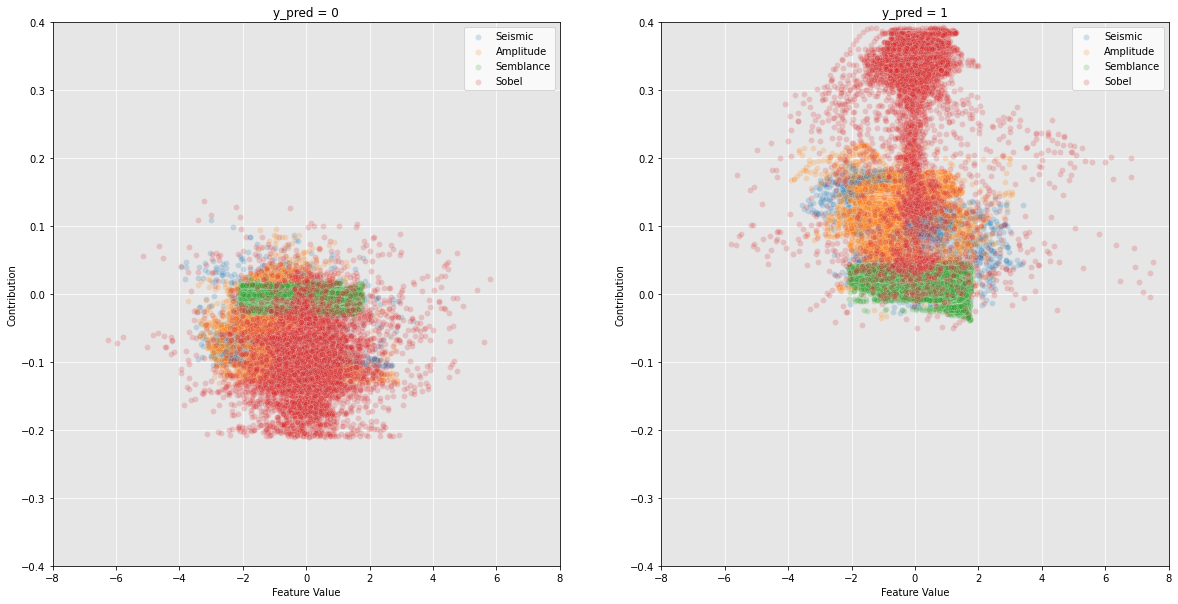

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax, num in zip(axes.flat, [0, 1]):
    
    df = data_df[data_df['y_true']==num]
    
    for title in ['Seismic', 'Amplitude', 'Semblance', 'Sobel']:
        
        sns.scatterplot(data=df, x=title, y=f'{title}_Contrib', ax=ax, alpha=0.2, label=title)
        
    ax.set_title(f'y_pred = {num}')
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Contribution')
    ax.set_ylim(-0.4, 0.4)
    ax.set_xlim(-8, 8)
    ax.set_facecolor('#E6E6E6')
    ax.set_axisbelow(True)
    ax.grid(color='w', linestyle='solid')
    
fig.savefig('Figures/Global_Channel_Contribution_Analysis_part2')
    
